# **Setting** #

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

 # Allows the use of display() for DataFrames
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"


# Setup notebook
from pathlib import Path
from IPython.display import display

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from lightgbm import LGBMRegressor # make for microsoft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Get Data** #

In [2]:
# Paths
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Get datas
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family','onpromotion', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil = pd.read_csv(
    comp_dir / 'oil.csv',
    usecols = ['date', 'dcoilwtico'],
    dtype={'dcoilwtico': 'float32'    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # assign new columns
)

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# Rearray to period

transactions =  pd.read_csv( comp_dir / 'transactions.csv',
                            parse_dates = ['date'], 
                            infer_datetime_format = True, 
                            )

oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil=oil.squeeze()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()




#  **Exploratory Data Analysis** #

In [3]:
display(store_sales.info())
display( store_sales.describe().T)
display( store_sales.head()) 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, ('1', 'AUTOMOTIVE', Period('2013-01-01', 'D')) to ('9', 'SEAFOOD', Period('2017-08-15', 'D'))
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sales        float32
 1   onpromotion  uint32 
dtypes: float32(1), uint32(1)
memory usage: 34.4 MB


None

,count,mean,std,min,25%,50%,75%,max
sales,3000888.0,356.758392,1093.275879,0.0,0.0,11.0,195.847252,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.000000,741.0


sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [4]:
store_sales['sales'].head()

def decompose_bike_sharing_demand(df, share_type='sales', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()
    

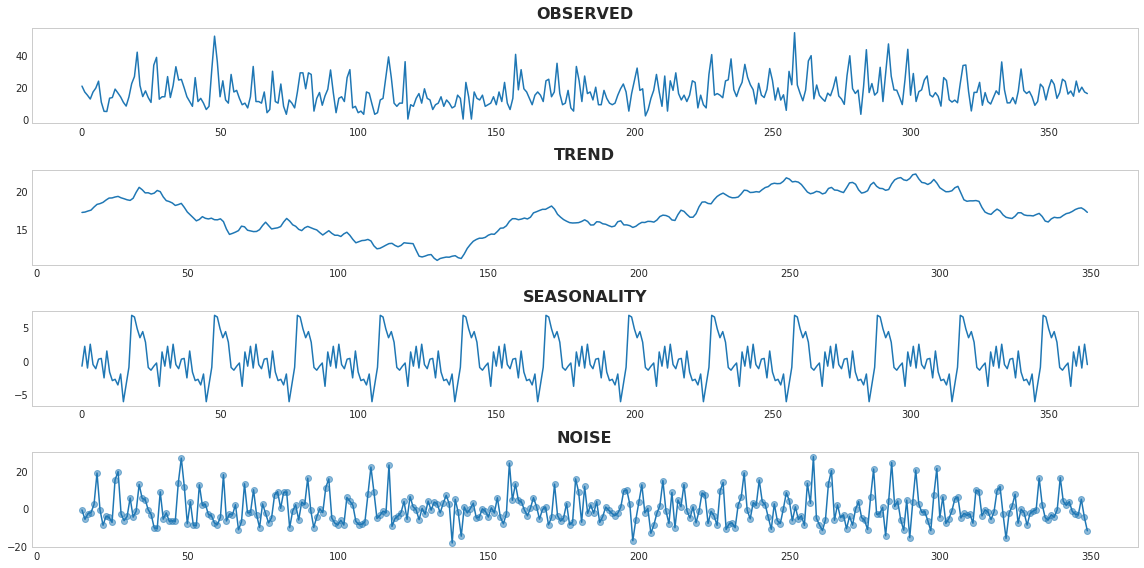

In [5]:
decompose_bike_sharing_demand(store_sales, samples= 365, period = 30 )

In [6]:
# transactions per store
transactions.info()

# average sales 
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

display(average_sales.info())
#ax = average_sales.plot(**plot_params, alpha = 0.5,  title='Averange Sales', ylabel='Items Sold')
#ax.legend();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        227 non-null    float32
 1   onpromotion  227 non-null    float64
dtypes: float32(1), float64(1)
memory usage: 4.4 KB


None

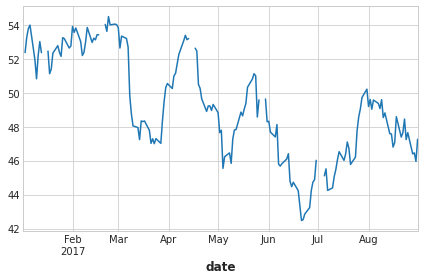

In [7]:
oil['2017'].plot()
plt.show()

In [8]:
#store_sales['salesLags'] = store_sales['sales'].shift(1)


# **Model with Oil** #


In [9]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"] 

display(y.head())

# y = y.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)




X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X_holidays = pd.get_dummies(holidays) # add columns on Holidays, more featured, way matricial


#X = X.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

fourier = CalendarFourier(freq='M', order=4)
dpOil = DeterministicProcess(
    index=oil.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

Xoil = dpOil.in_sample()

oil.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ... onpromotion        \
store_nbr                                            ...           9         
family     CELEBRATION CLEANING   DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                 ...                     
2017-01-01         0.0      0.0     0.0    0.000000  ...           0     0   
2017-01-02         0.0    332.0   376.0   44.980000  ...           0     0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...           0     0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...           0     0   
2017-01-05        40.0    918.0   853.0  137.005997  ...           0    21   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01             0            0                       0       0   
2017-01-02            13            0                       0       2   
2017-01-03            11            0                       0       1   
2017-01-04            15            0                       0       1   
2017-01-05             8            0                       0       1   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-01-01              0       0                          0       0  
2017-01-02              1       4                          0       0  
2017-01-03              2     150                          0       0  
2017-01-04              8       9                          0       0  
2017-01-05              1       5                          0       1  

[5 rows x 3564 columns]

date
2013-01-01          NaN
2013-01-02    93.139999
2013-01-03    92.970001
2013-01-04    93.120003
2013-01-07    93.199997
Freq: D, Name: dcoilwtico, dtype: float32

In [10]:
X1 = X.join( Xoil , on='date', rsuffix='RT').fillna(method = 'bfill')

X1.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            227 non-null    float64
 1   trend            227 non-null    float64
 2   s(2,7)           227 non-null    float64
 3   s(3,7)           227 non-null    float64
 4   s(4,7)           227 non-null    float64
 5   s(5,7)           227 non-null    float64
 6   s(6,7)           227 non-null    float64
 7   s(7,7)           227 non-null    float64
 8   sin(1,freq=M)    227 non-null    float64
 9   cos(1,freq=M)    227 non-null    float64
 10  sin(2,freq=M)    227 non-null    float64
 11  cos(2,freq=M)    227 non-null    float64
 12  sin(3,freq=M)    227 non-null    float64
 13  cos(3,freq=M)    227 non-null    float64
 14  sin(4,freq=M)    227 non-null    float64
 15  cos(4,freq=M)    227 non-null    float64
 16  NewYear          227 non-null    bool

In [11]:
X1.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"s(6,7)RT","s(7,7)RT","sin(1,freq=M)RT","cos(1,freq=M)RT","sin(2,freq=M)RT","cos(2,freq=M)RT","sin(3,freq=M)RT","cos(3,freq=M)RT","sin(4,freq=M)RT","cos(4,freq=M)RT"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


In [12]:
X2 = X1.join(X_holidays, on='date').fillna(0.0)
X2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 46 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               227 non-null    float64
 1   trend                                               227 non-null    float64
 2   s(2,7)                                              227 non-null    float64
 3   s(3,7)                                              227 non-null    float64
 4   s(4,7)                                              227 non-null    float64
 5   s(5,7)                                              227 non-null    float64
 6   s(6,7)                                              227 non-null    float64
 7   s(7,7)                                              227 non-null    float64
 8   sin(1,freq=M)                                       227

In [13]:
X2['dayslags'] = average_sales['sales'].shift(periods=15, freq='D')
#X2['daysweeklags'] = average_sales['sales'].shift(periods=7, freq='D')

X3 = X2.copy()
#display(X2.head(30))
X2.info()
X3.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 47 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               227 non-null    float64
 1   trend                                               227 non-null    float64
 2   s(2,7)                                              227 non-null    float64
 3   s(3,7)                                              227 non-null    float64
 4   s(4,7)                                              227 non-null    float64
 5   s(5,7)                                              227 non-null    float64
 6   s(6,7)                                              227 non-null    float64
 7   s(7,7)                                              227 non-null    float64
 8   sin(1,freq=M)                                       227

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo,dayslags
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [14]:
#X3['Oil'] = oil
X3['OilLagsOne'] = oil.shift(periods=1, freq='D')
X3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               227 non-null    float64
 1   trend                                               227 non-null    float64
 2   s(2,7)                                              227 non-null    float64
 3   s(3,7)                                              227 non-null    float64
 4   s(4,7)                                              227 non-null    float64
 5   s(5,7)                                              227 non-null    float64
 6   s(6,7)                                              227 non-null    float64
 7   s(7,7)                                              227 non-null    float64
 8   sin(1,freq=M)                                       227

In [15]:
#X3.fillna(method='ffill',  inplace=True) # drop values NaNs

X3.dropna(how='any', axis=0, inplace=True) # drop values NaNs

X3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 145 entries, 2017-01-18 to 2017-08-15
Freq: D
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               145 non-null    float64
 1   trend                                               145 non-null    float64
 2   s(2,7)                                              145 non-null    float64
 3   s(3,7)                                              145 non-null    float64
 4   s(4,7)                                              145 non-null    float64
 5   s(5,7)                                              145 non-null    float64
 6   s(6,7)                                              145 non-null    float64
 7   s(7,7)                                              145 non-null    float64
 8   sin(1,freq=M)                                       145

In [16]:
from sklearn.preprocessing import OneHotEncoder
 



#missingValueCount = X2.isnull().sum()
#
#print('Num_null: ' , missingValueCount.sum() )
#X2 = X2.dropna()
#X2 = X2.fillna(0)

#display(X2.info())



In [17]:
display(y.info())
y.head()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 3.1 MB


None

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ... onpromotion        \
store_nbr                                            ...           9         
family     CELEBRATION CLEANING   DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                 ...                     
2017-01-01         0.0      0.0     0.0    0.000000  ...           0     0   
2017-01-02         0.0    332.0   376.0   44.980000  ...           0     0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...           0     0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...           0     0   
2017-01-05        40.0    918.0   853.0  137.005997  ...           0    21   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01             0            0                       0       0   
2017-01-02            13            0                       0       2   
2017-01-03            11            0                       0       1   
2017-01-04            15            0                       0       1   
2017-01-05             8            0                       0       1   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-01-01              0       0                          0       0  
2017-01-02              1       4                          0       0  
2017-01-03              2     150                          0       0  
2017-01-04              8       9                          0       0  
2017-01-05              1       5                          0       1  

[5 rows x 3564 columns]

In [18]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 145 entries, 2017-01-18 to 2017-08-15
Freq: D
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               145 non-null    float64
 1   trend                                               145 non-null    float64
 2   s(2,7)                                              145 non-null    float64
 3   s(3,7)                                              145 non-null    float64
 4   s(4,7)                                              145 non-null    float64
 5   s(5,7)                                              145 non-null    float64
 6   s(6,7)                                              145 non-null    float64
 7   s(7,7)                                              145 non-null    float64
 8   sin(1,freq=M)                                       145

In [19]:
dateRange =  X3.index
dateRange

PeriodIndex(['2017-01-18', '2017-01-19', '2017-01-20', '2017-01-21',
             '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27',
             '2017-01-28', '2017-01-31',
             ...
             '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
             '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
             '2017-08-12', '2017-08-15'],
            dtype='period[D]', name='date', length=145)

In [20]:
label = store_sales.unstack(['store_nbr', 'family']).loc[dateRange] # include el range de X3
label.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 145 entries, 2017-01-18 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 2.0 MB


In [21]:
#model = LinearRegression(fit_intercept=False)
model = RandomForestRegressor(random_state = 42)

# model = LGBMRegressor(random_state = 42) "not work with  mulpli-columns"

model.fit(X3, label)
y_pred = pd.DataFrame(model.predict(X3), index=X3.index, columns=y.columns)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 145 entries, 2017-01-18 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float64(3564)
memory usage: 3.9 MB


CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

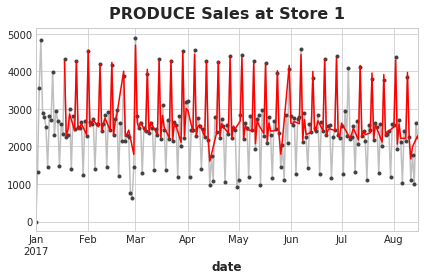

In [22]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params) # choose single store 1 and family equal produce. 
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='red')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

### Metric ###

In [23]:
Y = label.loc(axis=1)['sales', STORE_NBR, FAMILY]
Ypred = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY]

mae = np.round(mean_absolute_error(Y, Ypred), 3)    

mae

83.017

In [24]:
def train_time_series_with_folds(df, horizon=7*2):
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

We see a low in the price oil, at the end of 2014.

### Missing Values ###

In [25]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [26]:
average_sales_test = (
    df_test
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

average_sales

,sales,onpromotion
date,,
2017-01-01,6.780303,0.095398
2017-01-02,786.928406,6.628507
2017-01-03,619.740234,7.803591
2017-01-04,555.608032,12.860831
2017-01-05,436.375397,4.797980
...,...,...
2017-08-11,463.733856,7.956790
2017-08-12,444.798279,4.664422
2017-08-13,485.768616,5.209315


In [27]:
#df_test = df_test.loc['2017'] 
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          16 non-null     float64
 1   trend          16 non-null     float64
 2   s(2,7)         16 non-null     float64
 3   s(3,7)         16 non-null     float64
 4   s(4,7)         16 non-null     float64
 5   s(5,7)         16 non-null     float64
 6   s(6,7)         16 non-null     float64
 7   s(7,7)         16 non-null     float64
 8   sin(1,freq=M)  16 non-null     float64
 9   cos(1,freq=M)  16 non-null     float64
 10  sin(2,freq=M)  16 non-null     float64
 11  cos(2,freq=M)  16 non-null     float64
 12  sin(3,freq=M)  16 non-null     float64
 13  cos(3,freq=M)  16 non-null     float64
 14  sin(4,freq=M)  16 non-null     float64
 15  cos(4,freq=M)  16 non-null     float64
 16  NewYear        16 non-null     bool   
dtypes: bool(1), float64(16)
memory

In [28]:
#X_test2 = X_test.join(aveShift.rename('daysLags') , on='date').fillna(0.0)
print('Done')

Done


In [29]:

#X_test['dayslags'] = average_sales['sales'].loc[' 2017-08-16': '2017-08-30'] # last 15 days
#X_test.dropna(how='any', axis=0, inplace=True)
#X_test.info()

In [30]:
#X_test = X_test.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')
#X_test1 = X_test.join( Xoil , on='date', rsuffix='RT').fillna(method = 'bfill')
#X_test1.info()
X1_test = X_test.join( Xoil , on='date', rsuffix='RT').fillna(method = 'bfill')


X2_test = X1_test.join(X_holidays, on='date').fillna(0.0)
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 46 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               16 non-null     float64
 1   trend                                               16 non-null     float64
 2   s(2,7)                                              16 non-null     float64
 3   s(3,7)                                              16 non-null     float64
 4   s(4,7)                                              16 non-null     float64
 5   s(5,7)                                              16 non-null     float64
 6   s(6,7)                                              16 non-null     float64
 7   s(7,7)                                              16 non-null     float64
 8   sin(1,freq=M)                                       16 n

In [31]:
X2_test['daysLags']= average_sales['sales'].shift(periods=16, freq='D') # last 15 days, include extension it could is correct... 
#X2_test['daysweeklags'] = average_sales['sales'].shift(periods=16, freq='D')

#aveShift = average_sales['sales'].shift(periods=15, freq='D') # last 15 days

#aveShift.dropna(how='any', axis=0, inplace=True)
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 47 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               16 non-null     float64
 1   trend                                               16 non-null     float64
 2   s(2,7)                                              16 non-null     float64
 3   s(3,7)                                              16 non-null     float64
 4   s(4,7)                                              16 non-null     float64
 5   s(5,7)                                              16 non-null     float64
 6   s(6,7)                                              16 non-null     float64
 7   s(7,7)                                              16 non-null     float64
 8   sin(1,freq=M)                                       16 n

In [32]:
X2_test.head(20)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo,daysLags
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497.113831
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.729370
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,541.364746
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.568176
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,464.520599
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,541.915649
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.978210
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447.511200
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,402.786957


In [33]:
#X2_test['Oil'] = oil
X2_test['OilLagsOne'] = oil.shift(periods=1, freq='D')

X2_test.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               16 non-null     float64
 1   trend                                               16 non-null     float64
 2   s(2,7)                                              16 non-null     float64
 3   s(3,7)                                              16 non-null     float64
 4   s(4,7)                                              16 non-null     float64
 5   s(5,7)                                              16 non-null     float64
 6   s(6,7)                                              16 non-null     float64
 7   s(7,7)                                              16 non-null     float64
 8   sin(1,freq=M)                                       16 n

In [34]:
X2_test.fillna(method='ffill', inplace=True)


X2_test.head(20)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo,daysLags,OilLagsOne
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497.113831,47.570000
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.729370,46.799999
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,541.364746,47.070000
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.568176,48.590000
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,464.520599,48.590000
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,541.915649,48.590000
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.978210,47.389999
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447.511200,47.650002
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,402.786957,48.450001


In [35]:
#X2_test.dropna(how='any', axis=0, inplace=True) # drop values NaNs

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               16 non-null     float64
 1   trend                                               16 non-null     float64
 2   s(2,7)                                              16 non-null     float64
 3   s(3,7)                                              16 non-null     float64
 4   s(4,7)                                              16 non-null     float64
 5   s(5,7)                                              16 non-null     float64
 6   s(6,7)                                              16 non-null     float64
 7   s(7,7)                                              16 non-null     float64
 8   sin(1,freq=M)                                       16 n

In [36]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X2_test.index, columns=y.columns)
y_submit.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-16       3.49       0.0   4.67   2474.14  0.87   438.747150   
2017-08-17       4.54       0.0   3.43   2127.34  0.40   355.086788   
2017-08-18       5.91       0.0   2.43   1970.21  0.14   303.412928   
2017-08-19       5.27       0.0   3.31   2313.83  0.06   351.738029   
2017-08-20       4.08       0.0   3.33   2247.02  0.19   366.029082   

                                                     ... onpromotion         \
store_nbr                                            ...           9          
family     CELEBRATION CLEANING   DAIRY        DELI  ...   MAGAZINES  MEATS   
date                                                 ...                      
2017-08-16       21.96   866.95  852.20  145.520438  ...         0.0   0.09   
2017-08-17       20.92   681.29  727.26  120.874580  ...         0.0  19.27   
2017-08-18       16.58   608.90  606.62  132.064221  ...         0.0   0.20   
2017-08-19       11.57   575.05  733.86  133.769021  ...         0.0   0.51   
2017-08-20       16.01   733.90  708.87  125.607859  ...         0.0  11.76   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-08-16         15.17         0.00                    0.47    0.04   
2017-08-17         11.25         0.00                    0.01    0.17   
2017-08-18         10.27         0.00                    0.00   21.63   
2017-08-19         11.61         0.01                    0.02    0.03   
2017-08-20         12.05         0.00                    0.00    0.44   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-08-16           0.23    6.13                       1.24    0.66  
2017-08-17           0.52   14.46                       0.88    0.20  
2017-08-18           2.57    7.11                       3.90    0.15  
2017-08-19           0.46    7.04                       2.54    3.59  
2017-08-20           0.35   69.41                       1.00    0.33  

[5 rows x 3564 columns]

In [37]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X2_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [38]:
print('11:46')
y_submit.shape


11:46


(28512, 2)

## Pre-Processing ##

### Selection only Giants or Dwarfs ###

## Balance ##

In [39]:
# dividir set 



# from sklearn.utils import resample
# dfGiantsDownSample = resample(dfGiants, 
  #                           replace = False, # sample without replacement
   #                          n_samples = num_of_dwarf,
   #                          random_state =1 
 #                            )
#dfDownSampled = pd.concat([dfGiantsDownSample , dfDwarfs] )

#dfBalanced= dfDownSampled.reset_index(drop=True)

# dataStar = dfBalanced.sample(frac=1).reset_index(drop=True) # shuffle
# dfCopyStar = dataStar.copy()

## Visualization ##

## Correlation Linear ##

## Data Cleaning ##

# **Data Processing** #

### Train and test Set ###

In [40]:
## Stratified ##
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(data, data["variableStratificada"]):
#strat_train_set = housing.loc[train_index]
#strat_test_set = housing.loc[test_index]

#from  sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')

#from  sklearn.preprocessing import OneHotEncoder
#catEncoder = OneHotEncoder()

## numerical ##
#from  sklearn.pipeline import Pipeline
#from  sklearn.preprocessing import StandardScaler
#numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),])
# new_variable_transformed_numerical = num_pipeline.fit_transform(varible_numerica)

## numerical and categorial ##
#from sklearn import ColumnTransformer
#numerical_attribs = list(numerical_columns)
#categorical_attribs = list(categorial_columns)
#full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_attribs),("cat", OneHotEncoder(), categorical_attribs),])
#dataTotal_prepared = full_pipeline.fit_transform(dataTotal) 

## Target ## 

## Featuring Engineering ##

##  Pipeline and Featuring Scaling ##

 # **MODEL** # 

#### Models ####

In [41]:
### stratified CV ### see pag 136  Geron's book
#from sklearn.model_selection import StratifiedKFold
#from sklearn.base import clone
#skfolds = StratifiedKFold(n_splits=3, random_state=42)

# **Refinament** #

# **Deploy** #